In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
plt.rc("font", family="Malgun Gothic")
plt.rc("axes", unicode_minus = False)
import re
import joblib

from collections import Counter

from konlpy.tag import Okt,Mecab
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score,f1_score, recall_score, precision_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

## 데이터 불러오기

In [2]:
train = pd.read_csv('./data/train_data.csv')
test = pd.read_csv('./data/test_data.csv')
df_topic = pd.read_csv('./data/topic_dict.csv')

In [3]:
train.head()

,index,title,topic_idx
0,0,인천→핀란드 항공기 결항…휴가철 여행객 분통,4
1,1,실리콘밸리 넘어서겠다…구글 15조원 들여 美전역 거점화,4
2,2,이란 외무 긴장완화 해결책은 미국이 경제전쟁 멈추는 것,4
3,3,NYT 클린턴 측근韓기업 특수관계 조명…공과 사 맞물려종합,4
4,4,시진핑 트럼프에 중미 무역협상 조속 타결 희망,4


In [4]:
df_topic

,topic,topic_idx
0,IT과학,0
1,경제,1
2,사회,2
3,생활문화,3
4,세계,4
5,스포츠,5
6,정치,6


## EDA

In [46]:
train2 = pd.read_csv('./data/train_data.csv')
train2 = train2.merge(df_topic, on = "topic_idx", how = "left") 

In [49]:
train2["len"] = train2["title"].apply(lambda x : len(x)) 
train2["word_count"] = train2["title"].apply(lambda x : len(x.split())) 
train2["unique_word_count"] = train2["title"].apply(lambda x : len(set(x.split())))
train2.head()

,index,title,topic_idx,topic,len,word_count,unique_word_count
0,0,인천→핀란드 항공기 결항…휴가철 여행객 분통,4,세계,24,5,5
1,1,실리콘밸리 넘어서겠다…구글 15조원 들여 美전역 거점화,4,세계,30,6,6
2,2,이란 외무 긴장완화 해결책은 미국이 경제전쟁 멈추는 것,4,세계,30,8,8
3,3,NYT 클린턴 측근韓기업 특수관계 조명…공과 사 맞물려종합,4,세계,32,7,7
4,4,시진핑 트럼프에 중미 무역협상 조속 타결 희망,4,세계,25,7,7


In [50]:
train2.describe()

,index,topic_idx,len,word_count,unique_word_count
count,45654.000000,45654.000000,45654.000000,45654.000000,45654.000000
mean,22826.500000,3.163622,27.330552,6.588207,6.576642
std,13179.318932,1.932897,4.968172,1.474083,1.467776
min,0.000000,0.000000,4.000000,1.000000,1.000000
25%,11413.250000,2.000000,25.000000,6.000000,6.000000
50%,22826.500000,3.000000,28.000000,7.000000,7.000000
75%,34239.750000,5.000000,31.000000,8.000000,8.000000
max,45653.000000,6.000000,44.000000,13.000000,13.000000


[Text(0.5, 0, '기사 제목 길이'), Text(0, 0.5, '개수')]

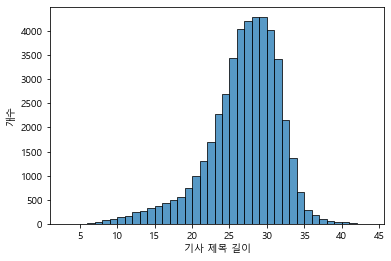

In [51]:
# Sub plot "len", "word_count", "unique_word_count" 시각화 
ax = sns.histplot(data = train2, x = 'len',shrink = 3)
ax.set(xlabel = '기사 제목 길이', ylabel = '개수')

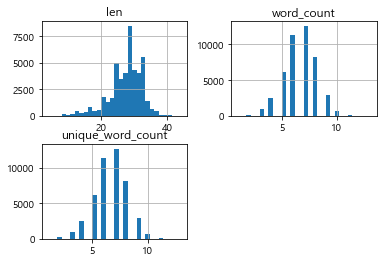

In [52]:
train2[["len", "word_count", "unique_word_count"]].hist(bins = 30) 
plt.show()

In [53]:
train2.head(1)

,index,title,topic_idx,topic,len,word_count,unique_word_count
0,0,인천→핀란드 항공기 결항…휴가철 여행객 분통,4,세계,24,5,5


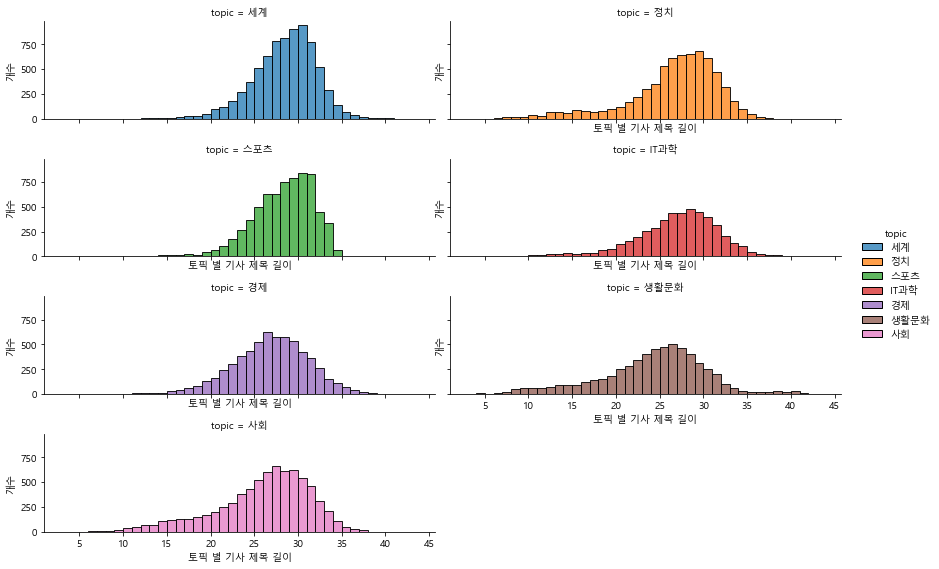

In [54]:
# 문장길이 
# displot으로 topic 별 "len"의 histplot 시각화하기 
ax = sns.displot(data = train2, x = "len", hue = "topic", col = "topic", \
    col_wrap = 2, height = 2, aspect = 3, shrink = 3)
ax.set(xlabel = '토픽 별 기사 제목 길이', ylabel = '개수')

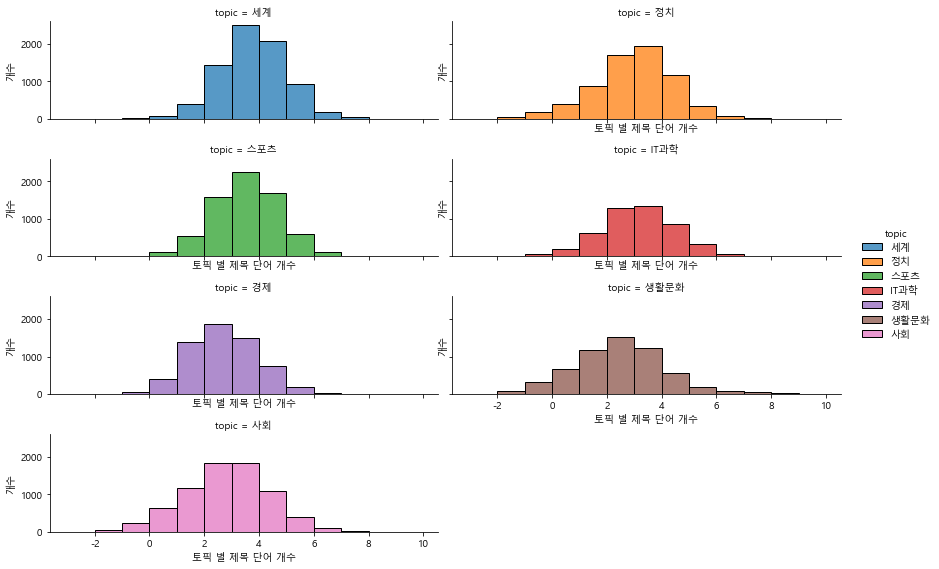

In [55]:
# 단어 수 
ax = sns.displot(data = train2, x = "word_count", hue = "topic", col = "topic", \
    col_wrap = 2, height = 2, aspect = 3, shrink = 9)
ax.set(xlabel = '토픽 별 제목 단어 개수', ylabel = '개수')

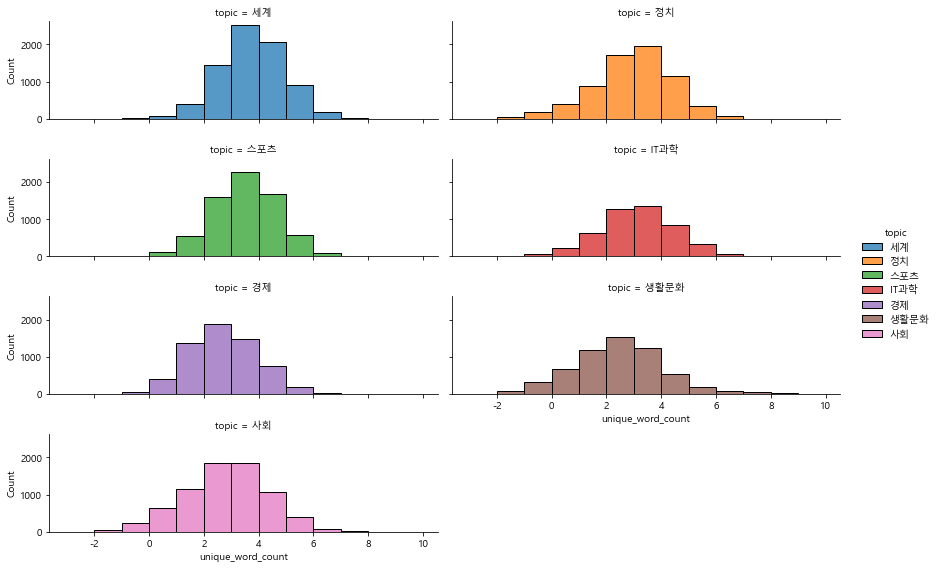

In [56]:
# 중복 제거 단어 수
sns.displot(data = train2, x = "unique_word_count", hue = "topic", col = "topic",\
     col_wrap = 2, height = 2, aspect = 3, shrink = 9)

## 데이터 전처리
- 자주 쓰이는 한자를 한글로 대체
- 특수문자 제거
- 영문자는 소문자로 통일
- 불용어 제거
- 한글자이지만 의미 있는 단어 추출
- 토큰화한 뒤 [명사, 동사, 형용사, 영단어]만 남기고 제거

### 중복 단어 추출

In [60]:
# 기존에 전처리 해서 저장했던 train_data2 파일 이용
word_dup = pd.read_csv('./data/train_data2.csv')
word_dup = word_dup.merge(df_topic)
word_dup.head(1)

,index,title,topic_idx,corpus,topic
0,0,인천→핀란드 항공기 결항…휴가철 여행객 분통,4,인천 핀란드 항공기 결항 휴가 여행객 분통,세계


In [61]:
import sys
import numpy as np

topic_list = list(set(word_dup.topic))

# 동적 변수 생성 코드

mod = sys.modules[__name__]
for topic in topic_list:
    setattr(mod, 'df_{}'.format(topic), word_dup[word_dup.topic == topic])
    setattr(mod, 'corpus_{}'.format(topic), 
           ' '.join(getattr(mod,'df_{}'.format(topic)).corpus.tolist()).split(' '))
    setattr(mod, 'most_{}'.format(topic),
           dict(Counter(getattr(mod,'corpus_{}'.format(topic))).most_common(100)))
    setattr(mod, 'least_{}'.format(topic),
           dict(list(dict(Counter(getattr(mod,'corpus_{}'.format(topic))).most_common()).items())[-100:]))

In [62]:
set(most_IT과학.keys()).intersection(set(most_경제)).intersection(set(most_사회)).\
intersection(set(most_생활문화)).intersection(set(most_세계)).intersection(set(most_스포츠)).intersection(set(most_정치))

{'종합', '한국'}

In [63]:
most_list = [most_IT과학, most_경제, most_사회, most_생활문화, most_세계, most_스포츠, most_정치]
vname = ['IT과학 뉴스', '경제 뉴스', '사회 뉴스', '생활문화 뉴스', '세계 뉴스', '스포츠 뉴스', '정치 뉴스']
for i in range(len(most_list)):
    for j in range(i+1, len(most_list)):
        print(f'{vname[i]}와 {vname[j]}의 공통 단어 : {len(set(most_list[i]).intersection(set(most_list[j])))}개')
        print(f'{set(most_list[i]).intersection(set(most_list[j]))}')
        print()

IT과학 뉴스와 경제 뉴스의 공통 단어 : 25개
{'중국', '카카오', '한국', '미국', '판매', '만원', '출시', 'lg', '서비스', '시장', '전자', '내년', '올해', '국내', 'kt', '최고', '게시판', '삼성', '확대', 'sk', '기업', '사업', '돌파', '종합', '코로나'}

IT과학 뉴스와 사회 뉴스의 공통 단어 : 13개
{'확대', '개최', '게시판', '기업', '한국', '올해', '사업', '영상', '만원', 'kt', '없다', '종합', '코로나'}

IT과학 뉴스와 생활문화 뉴스의 공통 단어 : 12개
{'세계', '개최', '보다', '체험', '국제', '최고', '한국', '올해', '게시판', '없다', '종합', '코로나'}

IT과학 뉴스와 세계 뉴스의 공통 단어 : 9개
{'중국', '세계', '공개', '최고', '기업', '한국', '미국', '없다', '종합'}

IT과학 뉴스와 스포츠 뉴스의 공통 단어 : 10개
{'게임', 'sk', '최고', '한국', '삼성', '종합', 'kt', '없다', 'lg', '코로나'}

IT과학 뉴스와 정치 뉴스의 공통 단어 : 8개
{'중국', '개최', '최고', '한국', '협력', '미국', '없다', '종합'}

경제 뉴스와 사회 뉴스의 공통 단어 : 17개
{'지원', '확대', '억원', '산업', '서울', '추진', '코로나', '게시판', '대다', '기업', '한국', '올해', '사업', '만원', 'kt', '종합', '그래픽'}

경제 뉴스와 생활문화 뉴스의 공통 단어 : 8개
{'서울', '최고', '현대', '한국', '올해', '게시판', '종합', '코로나'}

경제 뉴스와 세계 뉴스의 공통 단어 : 10개
{'지원', '중국', '최대', '추진', '대다', '최고', '기업', '한국', '미국', '종합'}

경제 뉴스와 스포츠 뉴스의 공통 단어 : 12개
{'kb', '코로나', 'sk', '

### 데이터 전처리 함수화

In [5]:
# 한자 등 텍스트 대치 함수
def preprocessing(text):
    # 개행문자 제거
    text = re.sub('\n', ' ', text)
      # 일부 한자 수정 
    name = {'↑':"상승",'↓':"하락",'㈜':"","銀":"은행","外人":"외국인",
            "日":"일본","美":"미국","北":"북한","英":"영국","中":"중국","與":"여당","靑":"청와대","野":"야당","伊":"이탈리아",
            "韓":"한국","南":"한국","獨":"독일","佛":"프랑스","檢":"검찰","銀":"은행","亞":"아시아","人":"사람","企":"기업",
            "前":"이전","車":"자동차","軍":"군대","코로나 19":"코로나", "朴":"박근혜", "文":"문재인", "安":"안철수", "展":"전시회", 
            "反":"반대", "故":"사망", "男":"남자", "女" : "여자", "硏":"연구"}
    for i, j in name.items():
        text = text.replace(i, j)
    # 한글, 영문만 남기고 모두 제거
    text = re.sub('[^가-힣ㄱ-ㅎㅏ-ㅣa-zA-Z]', ' ', text)  # 숫자나 한자(一-龥)는 모델 적용한 뒤 성능을 비교해 보고 다시 작성
    # 중복으로 생성된 공백값을 제거 
    text = re.sub('[\s]+', ' ', text)
    # 영문자를 소문자로
    text = text.lower()
    return text

def make_corpus(sentence):
    
    sentence = preprocessing(sentence)
    
    # 많이 나오지만 분석에 도움이 되지 않는 단어들 제거
    # 한 글자 단어 중 의미있는 단어는 포함하고 나머지는 제외
    del_list = ['같다','모든','하다', '있다', '되다', '이다', '돼다', '않다', '그렇다', '아니다', '이렇다', '그렇다', '어떻다',
               '우리','저자','통해','무엇','대한','대해','위해','또한','이야기','지금','모두','리즘','모습','먼저','이제','제대로',
               '얼마나','바로','이후','여러','누구','불구','동안','크게','서도','감히','로서','달리','만큼','비롯','매우','가까이',
               '미리','어쩌면','면서','더구나','오히려','게다가','관련','어디','역시','더욱','여기','저기','거기','결코','거나','앞서',
               '마치','경우','사이','종합','한국','내년','없다','내달','올해','앞두다','코로나'] + ['평','뇨','뤽','옵','며','꽤','록','주','봇','타','림','녀','펑','테', '단','겸','캡','압','좀','맏','텔','뽕','곤',
                '빠','자','현','판','납','댓','완','녜','준','푼','렉','샷','데','액','옐','텐','깃','곁','볼','바','옥','백','뿐','학','웅','실','호','갠','장','빵','숱','냐','윤',
                 '엔','즐','헛','샛','릴','관','밀','삼','융','결','맘','딜','낼','럼','승','벨','안','북','역','피','니','숄','텅','꽉','콘','탓','캣','초','겨','갱','얍','답','폴','및','하','용','붐',
                 '건','뭐','톰','닛','란','새','석','딸','보','삑','펀','낚','퇴','딕','윌','과','죽','킴','옆','이','낙','십','궤','쿵','분','일','남',
                 '욱','상','퀀','팬','젭','룬','숨','회','탕','캔','펠','토','둘','멸','트','팔','거','워','밸','곳','칩','컴','터','뼈','특','국','웡','펜','울','충','뮤','펄','쇄','계','령','신','별','덤','염','린','엽','숍','콕','색','번','육','확','넷','무','퍼','쾅','후',
                 '필','런','셧','제','잡','온','탭','꺽','팸','닷','킷','기','절','탈','핵','맹','툭','옻','삭','비','전','몽','톡','슈','았','앤','읍','엮','쿨','헬','왜','익','렬','털','각','블','획','첫','폭',
                 '처','짓','면','잭','사','치','빅','민','룸','걸','작','깅','만','왕','빙','님','칠','쑹','닥','수','뭘','덴','료','훙','녹','악','횡','앱','접','줌','여','숭','팩','뒤','랜','퓌','누','등','쉬','를','륙','포','쟁','협','저','홍','또','성','뼘','암','쇠','티','던',
                 '환','페','떼','샹','밍','더','옷','직','슨','벼','카','쿠','멈','청','힙','질','팽','마','명','증','랬','맥','탁','숙','박','취','쇤','캐','궂','움','콩','롱','핫','늘','략','원','귀','즈','키','죄','로','조','챙','롭','함','활','삶','좌','윈','측','몬','다','낭','정','넛','팝',
                 '의','즘','컷','램','변','핏','틴','줄','체','엄','간','루','켜','롬','행','규','셈','척','매','띤','슝','그','멍','딥','킥','음','놀','삐','푹','곡','솔','빼','권',
                 '르','세','위','홈','길','쥴','엡','립','외','빈','몇','머','툰','채','락','류','혁','베','나','능','뻔','슛','진','앰','식','컬','룽','족','끗','찬','켄','레','웨','곽','땐','쩐','김','헤','노','량','펩','둥','틀','황','쌍','응','메','텄','맨','디','텍','뱅','봉','송','넉','년','웰','알','룰','갓',
                 '속','펍','편','론','찌','쉑','친','휑','감','은','례','뎅','빔','태','렌','젬','짤','셀','틈','핸','칸','덜','득','몫','윅','널','짐','징','병','임','종','앗','냥','템','살','고','늦','양','뎀','솎','젤','랩','닉','릿','난','쯤','중','큐','날','링','두','소','콜','뼛','리','썸',
                 '항','짊','점','요','셰','킹','재','스','낮','픽','껜','툴','샵','룡','률','쏠','쉰','훈','묵','듯','힐','엘','순','시','윙','꿴','동','킨','러','롯','롤','혼','얀','붕','퐁','델','팀','잔','륭','킬','샘','선','경','내','심','슬','벌','놈','얼','추','객','택','욕','겹','즌','뻥','엠','웬','댕','츠','프','팅',
                 '오','적','덕','끌','억', '업','맵','늪','인','막','케','퀸','유','흑','브','턴','존','람','쉘','쓱','셋','섭','헌','파','휘','톤','입','효','설','월','낫','패','쾌','연','랄','팁','운','냉','샤','앞','착','도','쿡','캉','애','합','투','쭉','을','찍','버','생','뷰','휠','쪽','뚜','덧','싹','해','모','예','홀','드','젠','칙','부','에','잼'                                                                        
                 '몹','와','션','웃','최','열','혜','어','교','캠','불','궐','는','영','망','빨','너','것','네','려','율','쏙','맷','구','쩍', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm',
                 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']   
    
    # kernel dead가 뜨면 이모티콘 제거 해야함
    tokenizer = Okt()
    raw_pos_tagged = tokenizer.pos(sentence, norm=True, stem=True) # POS Tagging
    word_cleaned = []
    
    # 명사, 형용사, 동사, 영단어만 포함 
    for word in raw_pos_tagged: #  ('서울', 'Noun'),
        if word[1] in ['Noun','Alpha','Adjective','Verb']: # Foreign ==", " 와 같이 제외되어야할 항목들
            if word[0] not in del_list: # 한 글자로 이뤄진 단어들을 제외 & 원치 않는 단어들을 제외
                word_cleaned.append(word[0])

    return ' '.join(word_cleaned)


In [6]:
train['corpus'] = train.title.apply(lambda x : make_corpus(x))
test['corpus'] = test.title.apply(lambda x : make_corpus(x))

## TF-IDF 적용

In [7]:
tfidf_vect = TfidfVectorizer()
tfidf_vect.fit(train.corpus)
X_train_tfidf = tfidf_vect.transform(train.corpus)
X_test_tfidf = tfidf_vect.transform(test.corpus)

## 데이터 분할

In [8]:
# train/valid 데이터 셋 나누기.
def split_dataset(tfidf,df):
    X_data = tfidf
    y_data = df['topic_idx']

    # stratify=y_data Stratified 기반 분할, train 데이터의 30%를 평가 데이터 셋으로 사용. (70% 데이터 학습에 사용)
    X_train, X_test, y_train, y_test = \
    train_test_split(X_data, y_data, test_size=0.3, random_state=42, stratify=y_data)
    X_train = X_train.astype('float32')
    X_test = X_test.astype('float32')
    y_train = y_train.astype('float32')
    y_test = y_test.astype('float32')
    
    return (X_train, X_test, y_train, y_test)

In [9]:
# Validation
X_train, X_test, y_train, y_test = split_dataset(X_train_tfidf, train)

## 모델 학습 및 예측
- StratifiedKFold 이용
- LinearSVC 모델 적용
- GridSearch 적용

최종 모델 :  LinearSVC( C=0.1,tol=0.1, max_iter=100, random_state=0)

In [13]:
svc_clf = LinearSVC()

param_grid = { 
            "C":[1,0.1,0.01],
            "tol":[0.01, 0.001, 0.1,0.0001],
            "max_iter": [50,100,200]
              }

# "C":[1,0.1,0.01] -> 0.1
# "max_iter": [50,100,200] -> 100


grid = GridSearchCV(svc_clf, param_grid, refit=True, verbose=1)

grid.fit(X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


GridSearchCV(estimator=LinearSVC(),
             param_grid={'C': [1, 0.1, 0.01], 'max_iter': [50, 100, 200],
                         'tol': [0.01, 0.001, 0.1, 0.0001]},
             verbose=1)

In [14]:
print('The best parameters are ', grid.best_params_)

The best parameters are  {'C': 0.1, 'max_iter': 50, 'tol': 0.001}


In [15]:
# {'C': 0.1, 'max_iter': 50, 'tol': 0.001}
s_kf = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 0)

accuracy_ = []
for train_index in s_kf.split(X_train,y_train):
    
    model = LinearSVC( C=0.1,tol=0.001, max_iter=50, random_state=0)
    model.fit(X_train, y_train) # <- x_train_transformed (not x_train)
    
    y_pred = model.predict(X_test) # 예측 라벨
    accuracy_.append(accuracy_score(y_pred, y_test)) # 정확도 측정 및 기록

#print("각 분할의 정확도 :", accuracy_)
print("\n max 정확도 :", np.max(accuracy_))  


 max 정확도 : 0.8465357377527926


In [17]:
# {'C': 0.1, 'max_iter': 100, 'tol': 0.1}
s_kf = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 0)

accuracy_ = []
for train_index in s_kf.split(X_train,y_train):
    
    model = LinearSVC( C=0.1,tol=0.1, max_iter=100, random_state=0)
    model.fit(X_train, y_train) # <- x_train_transformed (not x_train)
    
    y_pred = model.predict(X_test) # 예측 라벨
    accuracy_.append(accuracy_score(y_pred, y_test)) # 정확도 측정 및 기록

#print("각 분할의 정확도 :", accuracy_)
print("\n max 정확도 :", np.max(accuracy_))  


 max 정확도 : 0.8466817551288603


In [25]:
svc_clf = LinearSVC( C=0.1,tol=0.1, max_iter=100, random_state=0)
svc_clf.fit(X_train, y_train)
pred = svc_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.8466817551288603

### 모델 저장

In [27]:
joblib.dump(svc_clf, './svc_model.pkl')

['./svc_model.pkl']